In [1]:
inpath = '/dls/science/groups/das/ExampleData/hdfmap_tests/i06/i06-1-353226.nxs'

# XAS Notebook

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

import hdfmap
print(hdfmap.module_info())


Python version 3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:24) [GCC 13.3.0]
 at: /scratch/grp66007/software/miniforge/envs/mmg_data_analysis/bin/python
 hdfmap version 0.9.0 (2025/03/31): /scratch/grp66007/software/miniforge/envs/mmg_data_analysis/lib/python3.10/site-packages/hdfmap/__init__.py
     numpy version: 2.1.2
      h5py version: 3.12.1
    hdf5plugin: 5.0.0
Running in directory: /scratch/grp66007/python/mmg_toolbox/notebooks



In [3]:
# Load data from NeXus file using HdfMap

nxs_map = hdfmap.create_nexus_map(inpath)

with nxs_map.load_hdf() as nxs:
    def rd(expr, default=''):
        return nxs_map.format_hdf(nxs, expr, default=default)

    # currently accounts for i06-1 and i10-1 metadata
    metadata = {
        "scan": rd('{filename}'),
        "cmd": rd('{(cmd|user_command|scan_command)}'),
        "title": rd('{title}', os.path.basename(inpath)),
        "endstation": rd('{end_station}', 'unknown'),
        "sample": rd('{sample_name}', ''),
        "energy": rd('{np.mean((fastEnergy|pgm_energy|energye|energyh)):.2f} eV'),
        "pol": rd('{polarisation?("lh")}'),
        "height": rd('{(em_y|hfm_y):.2f}', 0),
        "pitch": rd('{(em_pitch|hfm_pitch):.2f}', 0),
        "temperature": rd('{(T_sample|sample_temperature|lakeshore336_cryostat|lakeshore336_sample|itc3_device_sensor_temp?(300)):.2f} K'),
        "field": rd('{(field_z|sample_field|magnet_field|ips_demand_field?(0)):.2f} T'),
    }

    print(nxs_map.eval(nxs, '_(fastEnergy|pgm_energy|energye|energyh)'))
    print(nxs_map.eval(nxs, '_(C2|ca62sr|mcs16_data|mcse16_data|mcsh16_data)'))
    print(nxs_map.eval(nxs, '_(C1|ca61sr|mcs17_data|mcse17_data|mcsh17_data)'))
    print(nxs_map.eval(nxs, '_(C3|ca63sr|mcs18_data|mcse18_data|mcsh18_data|mcsd18_data)'))

    energy = nxs_map.eval(nxs, '(fastEnergy|pgm_energy|energye|energyh)')
    monitor = nxs_map.eval(nxs, '(C2|ca62sr|mcs16_data|mcse16_data|mcsh16_data)', default=1.0)
    tey = nxs_map.eval(nxs, '(C1|ca61sr|mcs17_data|mcse17_data|mcsh17_data)', default=np.ones(nxs_map.scannables_shape())) / monitor
    tfy = nxs_map.eval(nxs, '(C3|ca63sr|mcs18_data|mcse18_data|mcsh18_data|mcsd18_data)', default=np.ones(nxs_map.scannables_shape())) / monitor

print('\n'.join(f"{n:12}: {d}" for n, d in metadata.items()))

title = "{endstation} {sample} {scan}\nE = {energy}, pol = {pol}, T = {temperature}, B = {field}".format(**metadata)

/entry/instrument/fastEnergy/value
/entry/xas_entry/monitor/data
/entry/xas_entry/tey/absorbed_beam
/entry/xas_entry/tfy_ft/absorbed_beam
scan        : i06-1-353226.nxs
cmd         : scan fastEnergy 0.0 249.0 1.0 fesData 0.0 1.0
title       : i06-1-353226.nxs
endstation  : magnet
sample      : name not given
energy      : 768.66 eV
pol         : pc
height      : 0.00
pitch       : 0.00
temperature : 297.14 K
field       : 0.00 T


/tmp/ipykernel_3115974/294268461.py:31: RuntimeWarning: invalid value encountered in divide
  tey = nxs_map.eval(nxs, '(C1|ca61sr|mcs17_data|mcse17_data|mcsh17_data)', default=np.ones(nxs_map.scannables_shape())) / monitor
/tmp/ipykernel_3115974/294268461.py:32: RuntimeWarning: divide by zero encountered in divide
  tfy = nxs_map.eval(nxs, '(C3|ca63sr|mcs18_data|mcse18_data|mcsh18_data|mcsd18_data)', default=np.ones(nxs_map.scannables_shape())) / monitor


In [ ]:
# Load data from NeXus file from NXxas sub-entry
"""
import h5py 
with h5py.File(inpath, 'r') as nxs:
    # first entry
    entry = next(group for path, group in nxs.items() if group.attrs.get('NX_class', b'') == b'NXentry')
    nxxas = next(group for path, group in entry.items() if group.attrs.get('NX_class', b'') == b'NXsubentry' and group.get('definition').asstr()[()] == 'NXxas')
    print(f"NXxas path: \n{nxxas.name}")
    print(f"  {'\n  '.join(nxxas.keys())}")

    monitor = nxxas['monitor']['data'][()] if 'data' in nxxas['monitor'] else 1.0
    data = nxxas['data']  # or 'tey', 'tfy_ft'
    mode = data['mode'][()]
    energy = data['energy'][()]
    absorbed_beam = data['absorbed_beam'][()] / monitor
    tey = nxxas['tey']['absorbed_beam'][()] / monitor
    tfy = nxxas['tfy']['absorbed_beam'][()] / monitor
"""


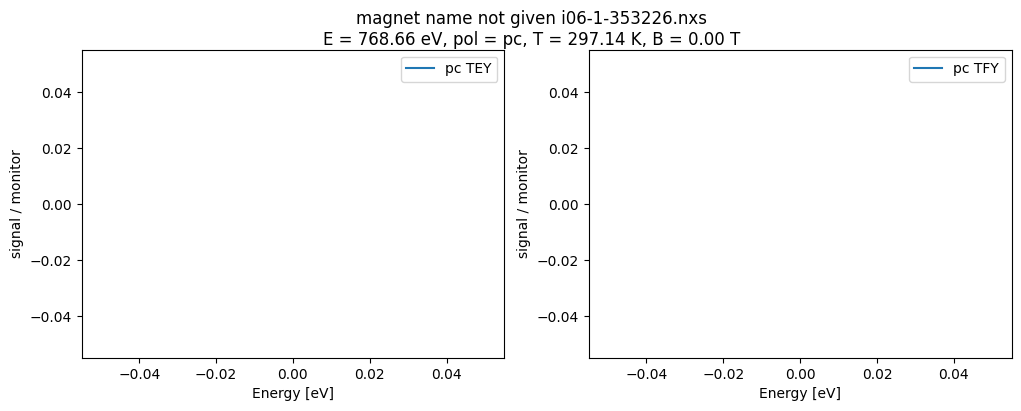

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(title)

ax[0].plot(energy, tey, '-', label=f"{metadata['pol']} TEY")
ax[1].plot(energy, tfy, '-', label=f"{metadata['pol']} TFY")

ax[0].set_xlabel('Energy [eV]')
ax[0].set_ylabel('signal / monitor')
ax[0].legend()

ax[1].set_xlabel('Energy [eV]')
ax[1].set_ylabel('signal / monitor')
ax[1].legend()